In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import RegressorChain
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.model_selection import cross_val_predict, KFold, StratifiedKFold
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.utils import check_X_y
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
import warnings
warnings.filterwarnings('ignore')

# -------------------------
# Configuration
# -------------------------
recession_targets = [
    "recession_probability",
    "1_month_recession_probability", 
    "3_month_recession_probability",
    "6_month_recession_probability",
]

chain_targets = recession_targets[:3]
target_6m = recession_targets[3]

# -------------------------
# Improved Data Preparation
# -------------------------
def prepare_data(df, split_date="2020-01-01"):
    """Prepare and split the data"""
    df["date"] = pd.to_datetime(df["date"])
    train_df = df[df["date"] < split_date].copy()
    test_df = df[df["date"] >= split_date].copy()
    
    X_train = train_df.drop(columns=recession_targets + ["date"])
    X_test = test_df.drop(columns=recession_targets + ["date"])
    y_train = train_df[recession_targets]
    y_test = test_df[recession_targets]
    
    return X_train, X_test, y_train, y_test, test_df

def clean_data(X_or_y):
    """Enhanced data cleaning with better handling of extreme values"""
    # Replace infinite values
    X_or_y = X_or_y.replace([np.inf, -np.inf], np.nan)
    
    # Forward fill then backward fill
    X_or_y = X_or_y.ffill().bfill()
    
    # Fill remaining NaN with median (more robust than 0)
    if hasattr(X_or_y, 'select_dtypes'):
        numeric_cols = X_or_y.select_dtypes(include=[np.number]).columns
        X_or_y[numeric_cols] = X_or_y[numeric_cols].fillna(X_or_y[numeric_cols].median())
    else:
        X_or_y = X_or_y.fillna(X_or_y.median())
    
    return X_or_y

def sanitize_columns(df):
    """Sanitize column names for LightGBM compatibility"""
    df.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in df.columns]
    return df

# -------------------------
# Improved Transformation Functions
# -------------------------
epsilon = 1e-8  # Smaller epsilon for better numerical stability

def safe_logit_transform(y):
    """Safer logit transformation with better clipping"""
    # Ensure y is in [0, 100] range
    y_clipped = np.clip(y, 0, 100)
    # Scale to [0, 1]
    y_scaled = y_clipped / 100.0
    # Apply epsilon clipping
    y_scaled = np.clip(y_scaled, epsilon, 1 - epsilon)
    # Logit transform
    return np.log(y_scaled / (1 - y_scaled))

def safe_inv_logit_transform(y_logit):
    """Safer inverse logit transformation"""
    # Clip extreme values to prevent overflow
    y_logit_clipped = np.clip(y_logit, -50, 50)
    y_prob = 1 / (1 + np.exp(-y_logit_clipped))
    return np.clip(y_prob * 100, 0, 100)

# -------------------------
# Enhanced Base Models
# -------------------------
class LGBMWrapper(BaseEstimator, RegressorMixin):
    """Improved LightGBM wrapper with better hyperparameters"""
    def __init__(self, params=None, num_boost_round=500, early_stopping_rounds=50):
        self.params = params or {
            "objective": "regression",
            "metric": "rmse",
            "max_depth": 6,
            "learning_rate": 0.05,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "min_child_samples": 20,
            "reg_alpha": 0.1,
            "reg_lambda": 0.1,
            "seed": 42,
            "verbose": -1,
        }
        self.num_boost_round = num_boost_round
        self.early_stopping_rounds = early_stopping_rounds
        self.model = None

    def fit(self, X, y):
        # Create validation set for early stopping
        val_size = max(10, int(0.1 * len(X)))
        train_X, val_X = X[:-val_size], X[-val_size:]
        train_y, val_y = y[:-val_size], y[-val_size:]
        
        dtrain = lgb.Dataset(train_X, label=train_y)
        dval = lgb.Dataset(val_X, label=val_y, reference=dtrain)
        
        self.model = lgb.train(
            self.params, 
            dtrain, 
            num_boost_round=self.num_boost_round,
            valid_sets=[dval],
            callbacks=[lgb.early_stopping(self.early_stopping_rounds, verbose=False)]
        )
        return self

    def predict(self, X):
        return self.model.predict(X)

class ImprovedCatBoostModel:
    """Enhanced CatBoost model with better hyperparameters"""
    def __init__(self):
        self.chain_model = None
        self.model_6m = None
        self.scaler = None
        
    def fit(self, X_train, y_train):
        # Scale features for better performance
        self.scaler = RobustScaler()
        X_train_scaled = pd.DataFrame(
            self.scaler.fit_transform(X_train),
            columns=X_train.columns,
            index=X_train.index
        )
        
        # Step 1: Chain model for first 3 targets
        y_train_chain = safe_logit_transform(y_train[chain_targets].values)
        
        # Create base model without use_best_model for RegressorChain compatibility
        base_model = CatBoostRegressor(
            iterations=600,
            learning_rate=0.05,
            depth=6,
            l2_leaf_reg=3,
            subsample=0.8,
            random_seed=42,
            loss_function="RMSE",
            verbose=False
        )
        
        self.chain_model = RegressorChain(base_model, order=[0, 1, 2])  # Explicit order
        self.chain_model.fit(X_train_scaled, y_train_chain)
        
        # Step 2: Separate model for 6-month target with validation
        X_train_6m = X_train_scaled.copy()
        chain_preds = safe_inv_logit_transform(self.chain_model.predict(X_train_scaled))
        X_train_6m[chain_targets] = chain_preds
        y_train_6m = safe_logit_transform(y_train[target_6m].values)
        
        # Split data for validation
        val_size = max(10, int(0.15 * len(X_train_6m)))
        X_train_6m_train = X_train_6m[:-val_size]
        X_train_6m_val = X_train_6m[-val_size:]
        y_train_6m_train = y_train_6m[:-val_size]
        y_train_6m_val = y_train_6m[-val_size:]
        
        self.model_6m = CatBoostRegressor(
            iterations=800,
            learning_rate=0.03,
            depth=8,
            l2_leaf_reg=5,
            subsample=0.8,
            random_seed=42,
            loss_function="RMSE",
            early_stopping_rounds=100,
            verbose=False,
            use_best_model=True
        )
        
        train_pool_6m = Pool(X_train_6m_train, y_train_6m_train)
        val_pool_6m = Pool(X_train_6m_val, y_train_6m_val)
        
        self.model_6m.fit(train_pool_6m, eval_set=val_pool_6m)
        
    def predict(self, X_test):
        X_test_scaled = pd.DataFrame(
            self.scaler.transform(X_test),
            columns=X_test.columns,
            index=X_test.index
        )
        
        # Predict first 3 targets
        preds_chain_logit = self.chain_model.predict(X_test_scaled)
        preds_chain = safe_inv_logit_transform(preds_chain_logit)
        
        # Predict 6-month target
        X_test_6m = X_test_scaled.copy()
        X_test_6m[chain_targets] = preds_chain
        pred_6m = safe_inv_logit_transform(self.model_6m.predict(Pool(X_test_6m)))
        
        # Combine predictions
        all_preds = np.column_stack([preds_chain, pred_6m])
        return np.clip(all_preds, 0, 100)

class ImprovedLightGBMModel:
    """Enhanced LightGBM model"""
    def __init__(self):
        self.chain_model = None
        self.model_6m = None
        self.scaler = None
        self.lgb_params = {
            "objective": "regression",
            "metric": "rmse",
            "max_depth": 8,
            "learning_rate": 0.05,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "min_child_samples": 30,
            "reg_alpha": 0.3,
            "reg_lambda": 0.3,
            "seed": 42,
            "verbose": -1,
        }
        
    def fit(self, X_train, y_train):
        X_train = sanitize_columns(X_train)
        
        # Scale features
        self.scaler = RobustScaler()
        X_train_scaled = pd.DataFrame(
            self.scaler.fit_transform(X_train),
            columns=X_train.columns,
            index=X_train.index
        )
        
        # Step 1: Chain model
        y_train_chain = safe_logit_transform(y_train[chain_targets].values)
        chain_base = LGBMWrapper(params=self.lgb_params, num_boost_round=500)
        self.chain_model = RegressorChain(chain_base, order=[0, 1, 2])
        self.chain_model.fit(X_train_scaled, y_train_chain)
        
        # Step 2: 6-month model
        X_train_6m = X_train_scaled.copy()
        chain_preds = safe_inv_logit_transform(self.chain_model.predict(X_train_scaled))
        X_train_6m[chain_targets] = chain_preds
        y_train_6m = safe_logit_transform(y_train[target_6m].values)
        
        # Use validation for early stopping
        val_size = max(10, int(0.2 * len(X_train_6m)))
        dtrain_6m = lgb.Dataset(X_train_6m[:-val_size], label=y_train_6m[:-val_size])
        dval_6m = lgb.Dataset(X_train_6m[-val_size:], label=y_train_6m[-val_size:], reference=dtrain_6m)
        
        self.model_6m = lgb.train(
            self.lgb_params, 
            dtrain_6m, 
            num_boost_round=500,
            valid_sets=[dval_6m],
            callbacks=[lgb.early_stopping(50, verbose=False)]
        )
        
    def predict(self, X_test):
        X_test = sanitize_columns(X_test)
        X_test_scaled = pd.DataFrame(
            self.scaler.transform(X_test),
            columns=X_test.columns,
            index=X_test.index
        )
        
        # Predict first 3 targets
        preds_chain_logit = self.chain_model.predict(X_test_scaled)
        preds_chain = safe_inv_logit_transform(preds_chain_logit)
        
        # Predict 6-month target
        X_test_6m = X_test_scaled.copy()
        X_test_6m[chain_targets] = preds_chain
        pred_6m_logit = self.model_6m.predict(X_test_6m)
        pred_6m = safe_inv_logit_transform(pred_6m_logit)
        
        # Combine predictions
        all_preds = np.column_stack([preds_chain, pred_6m])
        return np.clip(all_preds, 0, 100)

class ImprovedRandomForestModel:
    """Enhanced Random Forest model"""
    def __init__(self):
        self.chain_model = None
        self.model_6m = None
        self.scaler = None
        
    def fit(self, X_train, y_train):
        # Scale features
        self.scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(
            self.scaler.fit_transform(X_train),
            columns=X_train.columns,
            index=X_train.index
        )
        
        # Step 1: Chain model with better hyperparameters
        y_train_chain = safe_logit_transform(y_train[chain_targets].values)
        rf_base = RandomForestRegressor(
            n_estimators=500,
            max_depth=12,
            min_samples_split=10,
            min_samples_leaf=5,
            max_features=0.8,
            max_samples=0.8,
            random_state=42,
            n_jobs=-1
        )
        
        self.chain_model = RegressorChain(base_estimator=rf_base, order=[0, 1, 2])
        self.chain_model.fit(X_train_scaled, y_train_chain)
        
        # Step 2: 6-month model
        X_train_6m = X_train_scaled.copy()
        chain_preds = safe_inv_logit_transform(self.chain_model.predict(X_train_scaled))
        X_train_6m[chain_targets] = chain_preds
        y_train_6m = safe_logit_transform(y_train[target_6m].values)
        
        self.model_6m = RandomForestRegressor(
            n_estimators=500,
            max_depth=12,
            min_samples_split=10,
            min_samples_leaf=5,
            max_features=0.8,
            max_samples=0.8,
            random_state=42,
            n_jobs=-1
        )
        
        self.model_6m.fit(X_train_6m, y_train_6m)
        
    def predict(self, X_test):
        X_test_scaled = pd.DataFrame(
            self.scaler.transform(X_test),
            columns=X_test.columns,
            index=X_test.index
        )
        
        # Predict first 3 targets
        preds_chain_logit = self.chain_model.predict(X_test_scaled)
        preds_chain = safe_inv_logit_transform(preds_chain_logit)
        
        # Predict 6-month target
        X_test_6m = X_test_scaled.copy()
        X_test_6m[chain_targets] = preds_chain
        pred_6m = safe_inv_logit_transform(self.model_6m.predict(X_test_6m))
        
        # Combine predictions
        all_preds = np.column_stack([preds_chain, pred_6m])
        return np.clip(all_preds, 0, 100)

# -------------------------
# Significantly Improved Stacking Ensemble
# -------------------------
class ImprovedStackingEnsemble:
    """Enhanced stacking ensemble with multiple improvements"""
    def __init__(self, meta_model=None, cv_folds=8, use_feature_engineering=True):
        self.catboost_model = ImprovedCatBoostModel()
        self.lightgbm_model = ImprovedLightGBMModel() 
        self.rf_model = ImprovedRandomForestModel()
        self.meta_models = {}
        self.cv_folds = cv_folds
        self.use_feature_engineering = use_feature_engineering
        self.meta_scaler = {}
        
        # Better meta-model with regularization
        if meta_model is None:
            self.meta_model_template = ElasticNet(
                alpha=0.1, 
                l1_ratio=0.5, 
                random_state=42,
                max_iter=2000
            )
        else:
            self.meta_model_template = meta_model
            
    def _engineer_meta_features(self, cb_preds, lgb_preds, rf_preds):
        """Create engineered features for meta-learning"""
        features = []
        
        # Original predictions
        features.extend([cb_preds, lgb_preds, rf_preds])
        
        if self.use_feature_engineering:
            # Ensemble statistics
            mean_pred = (cb_preds + lgb_preds + rf_preds) / 3
            features.append(mean_pred)
            
            # Weighted averages (based on typical model performance)
            weighted_avg = 0.4 * cb_preds + 0.35 * lgb_preds + 0.25 * rf_preds
            features.append(weighted_avg)
            
            # Variance/disagreement measures
            pred_std = np.std([cb_preds, lgb_preds, rf_preds], axis=0)
            features.append(pred_std)
            
            # Min and Max predictions
            features.append(np.min([cb_preds, lgb_preds, rf_preds], axis=0))
            features.append(np.max([cb_preds, lgb_preds, rf_preds], axis=0))
            
            # Pairwise differences
            features.append(np.abs(cb_preds - lgb_preds))
            features.append(np.abs(cb_preds - rf_preds))
            features.append(np.abs(lgb_preds - rf_preds))
        
        return np.column_stack(features)
    
    def _get_cv_predictions(self, X_train, y_train):
        """Generate cross-validation predictions with improved strategy"""
        # Use stratified sampling based on recession probability quantiles
        recession_prob = y_train['recession_probability'].values
        bins = np.quantile(recession_prob, [0, 0.25, 0.5, 0.75, 1.0])
        stratify_labels = np.digitize(recession_prob, bins) - 1
        
        skf = StratifiedKFold(n_splits=self.cv_folds, shuffle=True, random_state=42)
        
        # Initialize arrays
        n_samples = X_train.shape[0]
        n_targets = len(recession_targets)
        
        catboost_cv_preds = np.zeros((n_samples, n_targets))
        lightgbm_cv_preds = np.zeros((n_samples, n_targets))
        rf_cv_preds = np.zeros((n_samples, n_targets))
        
        print("Generating cross-validation predictions with stratified folds...")
        
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, stratify_labels)):
            print(f"Processing fold {fold_idx + 1}/{self.cv_folds}")
            
            X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_fold_train = y_train.iloc[train_idx]
            
            # CatBoost predictions
            cb_model = ImprovedCatBoostModel()
            cb_model.fit(X_fold_train, y_fold_train)
            catboost_cv_preds[val_idx] = cb_model.predict(X_fold_val)
            
            # LightGBM predictions  
            lgb_model = ImprovedLightGBMModel()
            lgb_model.fit(X_fold_train, y_fold_train)
            lightgbm_cv_preds[val_idx] = lgb_model.predict(X_fold_val)
            
            # Random Forest predictions
            rf_model = ImprovedRandomForestModel()
            rf_model.fit(X_fold_train, y_fold_train)
            rf_cv_preds[val_idx] = rf_model.predict(X_fold_val)
            
        return catboost_cv_preds, lightgbm_cv_preds, rf_cv_preds
    
    def fit(self, X_train, y_train):
        """Fit the improved stacking ensemble"""
        print("Training enhanced base models...")
        
        # Train base models on full training data
        self.catboost_model.fit(X_train, y_train)
        self.lightgbm_model.fit(X_train, y_train) 
        self.rf_model.fit(X_train, y_train)
        
        # Generate cross-validation predictions
        catboost_cv_preds, lightgbm_cv_preds, rf_cv_preds = self._get_cv_predictions(X_train, y_train)
        
        print("Training enhanced meta-models...")
        
        # Train separate meta-model for each target
        for i, target in enumerate(recession_targets):
            # Create enhanced meta features
            meta_features = self._engineer_meta_features(
                catboost_cv_preds[:, i],
                lightgbm_cv_preds[:, i],
                rf_cv_preds[:, i]
            )
            
            # Scale meta features
            scaler = StandardScaler()
            meta_features_scaled = scaler.fit_transform(meta_features)
            self.meta_scaler[target] = scaler
            
            # Train meta-model with cross-validation for hyperparameter tuning
            meta_model = clone(self.meta_model_template)
            
            # Use nested CV for meta-model validation
            kf_inner = KFold(n_splits=3, shuffle=True, random_state=42)
            best_score = -np.inf
            best_alpha = self.meta_model_template.alpha
            
            for alpha in [0.01, 0.05, 0.1, 0.5, 1.0, 2.0]:
                meta_model_test = clone(self.meta_model_template)
                meta_model_test.set_params(alpha=alpha)
                
                cv_scores = []
                for train_inner_idx, val_inner_idx in kf_inner.split(meta_features_scaled):
                    meta_model_test.fit(meta_features_scaled[train_inner_idx], y_train[target].values[train_inner_idx])
                    pred = meta_model_test.predict(meta_features_scaled[val_inner_idx])
                    score = r2_score(y_train[target].values[val_inner_idx], pred)
                    cv_scores.append(score)
                
                avg_score = np.mean(cv_scores)
                if avg_score > best_score:
                    best_score = avg_score
                    best_alpha = alpha
            
            # Train final meta-model with best hyperparameters
            meta_model.set_params(alpha=best_alpha)
            meta_model.fit(meta_features_scaled, y_train[target])
            self.meta_models[target] = meta_model
            
            print(f"Target {target}: Best alpha = {best_alpha:.3f}, CV R² = {best_score:.4f}")
        
        print("Enhanced ensemble training completed!")
        
    def predict(self, X_test):
        """Make predictions using the enhanced stacking ensemble"""
        # Get predictions from all base models
        catboost_preds = self.catboost_model.predict(X_test)
        lightgbm_preds = self.lightgbm_model.predict(X_test)
        rf_preds = self.rf_model.predict(X_test)
        
        # Generate final predictions using enhanced meta-models
        final_predictions = np.zeros_like(catboost_preds)
        
        for i, target in enumerate(recession_targets):
            # Create enhanced meta features
            meta_features = self._engineer_meta_features(
                catboost_preds[:, i],
                lightgbm_preds[:, i],
                rf_preds[:, i]
            )
            
            # Scale meta features
            meta_features_scaled = self.meta_scaler[target].transform(meta_features)
            
            # Predict using meta-model
            final_predictions[:, i] = self.meta_models[target].predict(meta_features_scaled)
            
        return np.clip(final_predictions, 0, 100)

# -------------------------
# Additional Ensemble Methods
# -------------------------
class WeightedEnsemble:
    """Simple weighted ensemble as baseline comparison"""
    def __init__(self, weights=None):
        self.catboost_model = ImprovedCatBoostModel()
        self.lightgbm_model = ImprovedLightGBMModel() 
        self.rf_model = ImprovedRandomForestModel()
        self.weights = weights or [0.4, 0.35, 0.25]  # CatBoost, LightGBM, RF
        
    def fit(self, X_train, y_train):
        print("Training weighted ensemble base models...")
        self.catboost_model.fit(X_train, y_train)
        self.lightgbm_model.fit(X_train, y_train) 
        self.rf_model.fit(X_train, y_train)
        
    def predict(self, X_test):
        cb_preds = self.catboost_model.predict(X_test)
        lgb_preds = self.lightgbm_model.predict(X_test)
        rf_preds = self.rf_model.predict(X_test)
        
        weighted_preds = (self.weights[0] * cb_preds + 
                         self.weights[1] * lgb_preds + 
                         self.weights[2] * rf_preds)
        
        return np.clip(weighted_preds, 0, 100)

# -------------------------
# Enhanced Evaluation and Plotting
# -------------------------
def evaluate_model(y_true, y_pred, model_name="Model"):
    """Enhanced evaluation with additional metrics"""
    print(f"\n=== {model_name} Evaluation ===")
    
    metrics_df = []
    for i, target in enumerate(recession_targets):
        mae = mean_absolute_error(y_true[target], y_pred[:, i])
        rmse = mean_squared_error(y_true[target], y_pred[:, i], squared=False)
        r2 = r2_score(y_true[target], y_pred[:, i])
        
        # Additional metrics
        mape = np.mean(np.abs((y_true[target] - y_pred[:, i]) / np.maximum(y_true[target], 1))) * 100
        max_error = np.max(np.abs(y_true[target] - y_pred[:, i]))
        
        metrics_df.append({
            'Target': target,
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2,
            'MAPE': mape,
            'Max_Error': max_error
        })
        
        print(f"{target}: MAE={mae:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}, MAPE={mape:.2f}%")
    
    return pd.DataFrame(metrics_df)

def plot_enhanced_predictions(y_test, predictions_dict, test_df):
    """Enhanced plotting with residuals and confidence intervals"""
    fig, axes = plt.subplots(len(recession_targets), 2, figsize=(20, 4*len(recession_targets)))
    if len(recession_targets) == 1:
        axes = axes.reshape(1, -1)
    
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
    
    for i, target in enumerate(recession_targets):
        # Left plot: Time series
        axes[i, 0].plot(test_df.index, y_test[target], label="Actual", 
                       linewidth=3, alpha=0.8, color='black')
        
        for j, (model_name, preds) in enumerate(predictions_dict.items()):
            axes[i, 0].plot(test_df.index, preds[:, i], 
                           label=f"{model_name}", 
                           linestyle="--", alpha=0.7, 
                           color=colors[j % len(colors)], linewidth=2)
        
        axes[i, 0].set_title(f"{target}: Actual vs Predicted")
        axes[i, 0].legend()
        axes[i, 0].grid(True, alpha=0.3)
        
        # Right plot: Residuals for best model
        best_model = min(predictions_dict.keys(), 
                        key=lambda x: mean_absolute_error(y_test[target], predictions_dict[x][:, i]))
        residuals = y_test[target] - predictions_dict[best_model][:, i]
        
        axes[i, 1].scatter(predictions_dict[best_model][:, i], residuals, alpha=0.6)
        axes[i, 1].axhline(y=0, color='red', linestyle='--')
        axes[i, 1].set_xlabel(f'Predicted {target}')
        axes[i, 1].set_ylabel('Residuals')
        axes[i, 1].set_title(f'{target}: Residuals ({best_model})')
        axes[i, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# -------------------------
# Enhanced Main Pipeline
# -------------------------
def run_enhanced_ensemble_pipeline(df):
    """Run the enhanced ensemble pipeline"""
    print("=" * 80)
    print("ENHANCED RECESSION PREDICTION ENSEMBLE PIPELINE")
    print("=" * 80)
    
    # Prepare data
    X_train, X_test, y_train, y_test, test_df = prepare_data(df)
    
    # Enhanced data cleaning
    X_train = clean_data(X_train)
    X_test = clean_data(X_test)
    y_train = clean_data(y_train)
    y_test = clean_data(y_test)
    
    print(f"Training data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")
    print(f"Training target range: {y_train.min().min():.2f} to {y_train.max().max():.2f}")
    
    # Initialize enhanced models
    models = {
        'Enhanced CatBoost': ImprovedCatBoostModel(),
        'Enhanced LightGBM': ImprovedLightGBMModel(),
        'Enhanced Random Forest': ImprovedRandomForestModel(),
        'Weighted Ensemble': WeightedEnsemble(),
        'Enhanced Stacking': ImprovedStackingEnsemble(cv_folds=8, use_feature_engineering=True)
    }
    
    # Train models and collect predictions
    predictions = {}
    metrics_results = []
    training_times = {}
    
    import time
    
    for model_name, model in models.items():
        print(f"\n{'='*25} Training {model_name} {'='*25}")
        
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        training_times[model_name] = training_time
        
        print(f"Making predictions with {model_name}...")
        start_time = time.time()
        preds = model.predict(X_test)
        prediction_time = time.time() - start_time
        
        predictions[model_name] = preds
        
        # Evaluate
        metrics = evaluate_model(y_test, preds, model_name)
        metrics['Model'] = model_name
        metrics['Training_Time'] = training_time
        metrics['Prediction_Time'] = prediction_time
        metrics_results.append(metrics)
        
        print(f"Training time: {training_time:.2f}s, Prediction time: {prediction_time:.4f}s")
    
    # Combine metrics for comparison
    all_metrics = pd.concat(metrics_results, ignore_index=True)
    
    # Enhanced plotting
    plot_enhanced_predictions(y_test, predictions, test_df)
    
    # Detailed analysis
    print("\n" + "="*100)
    print("COMPREHENSIVE MODEL COMPARISON")
    print("="*100)
    
    # Performance comparison
    performance_summary = all_metrics.groupby('Model').agg({
        'MAE': 'mean',
        'RMSE': 'mean', 
        'R2': 'mean',
        'MAPE': 'mean',
        'Training_Time': 'first'
    }).round(4)
    
    print("\nOverall Performance Summary (Average across all targets):")
    print(performance_summary.sort_values('R2', ascending=False))
    
    # Target-specific analysis
    print("\nDetailed Performance by Target:")
    pivot_metrics = all_metrics.pivot_table(
        index='Target', 
        columns='Model', 
        values=['MAE', 'RMSE', 'R2', 'MAPE']
    ).round(4)
    
    for metric in ['MAE', 'RMSE', 'R2', 'MAPE']:
        print(f"\n{metric}:")
        metric_df = pivot_metrics[metric]
        if metric in ['MAE', 'RMSE', 'MAPE']:
            best_cols = metric_df.idxmin(axis=1)
        else:  # R2
            best_cols = metric_df.idxmax(axis=1)
        
        print(metric_df)
        print(f"Best model per target: {best_cols.to_dict()}")
    
    # Model ranking
    print("\n" + "="*50)
    print("MODEL RANKING ANALYSIS")
    print("="*50)
    
    # Calculate average rank across all metrics and targets
    ranking_data = []
    for metric in ['MAE', 'RMSE', 'MAPE']:  # Lower is better
        ranks = pivot_metrics[metric].rank(axis=1, ascending=True)
        ranking_data.append(ranks)
    
    # R2 - higher is better
    r2_ranks = pivot_metrics['R2'].rank(axis=1, ascending=False)
    ranking_data.append(r2_ranks)
    
    # Average ranking
    avg_ranking = pd.concat(ranking_data).groupby(level=0).mean().mean(axis=0).sort_values()
    
    print("\nAverage Model Ranking (1=best, 5=worst):")
    for i, (model, rank) in enumerate(avg_ranking.items(), 1):
        print(f"{i}. {model}: {rank:.2f}")
    
    # Statistical significance test
    print("\n" + "="*50)
    print("MODEL IMPROVEMENT ANALYSIS")
    print("="*50)
    
    # Compare Enhanced Stacking vs best individual model
    enhanced_stacking_metrics = all_metrics[all_metrics['Model'] == 'Enhanced Stacking']
    best_individual = performance_summary.drop('Enhanced Stacking').sort_values('R2', ascending=False).index[0]
    best_individual_metrics = all_metrics[all_metrics['Model'] == best_individual]
    
    print(f"\nEnhanced Stacking vs {best_individual}:")
    for metric in ['MAE', 'RMSE', 'R2', 'MAPE']:
        stacking_val = enhanced_stacking_metrics[metric].mean()
        individual_val = best_individual_metrics[metric].mean()
        
        if metric in ['MAE', 'RMSE', 'MAPE']:
            improvement = ((individual_val - stacking_val) / individual_val) * 100
            direction = "lower is better"
        else:  # R2
            improvement = ((stacking_val - individual_val) / individual_val) * 100
            direction = "higher is better"
        
        print(f"{metric}: Stacking={stacking_val:.4f}, {best_individual}={individual_val:.4f}")
        print(f"  → Improvement: {improvement:+.2f}% ({direction})")
    
    return models, predictions, all_metrics

# -------------------------
# Model Persistence and Deployment
# -------------------------
def save_enhanced_models(models, save_dir="enhanced_ensemble"):
    """Save all enhanced trained models"""
    os.makedirs(save_dir, exist_ok=True)
    
    print(f"\n{'='*60}")
    print("SAVING ENHANCED MODELS")
    print("="*60)
    
    saved_models = {}
    model_info = {}
    
    for model_name, model in models.items():
        safe_name = model_name.lower().replace(' ', '_').replace('-', '_')
        filename = f"{safe_name}.pkl"
        filepath = os.path.join(save_dir, filename)
        
        try:
            with open(filepath, 'wb') as f:
                pickle.dump(model, f)
            
            file_size = os.path.getsize(filepath) / (1024 * 1024)
            print(f"✓ {model_name} saved as {filename} ({file_size:.2f} MB)")
            saved_models[model_name] = filepath
            
            # Store model information
            model_info[model_name] = {
                'type': type(model).__name__,
                'file_size_mb': file_size,
                'features_required': getattr(model, 'feature_names_', 'Unknown')
            }
            
        except Exception as e:
            print(f"✗ Failed to save {model_name}: {str(e)}")
    
    # Save comprehensive metadata
    metadata = {
        'models': list(models.keys()),
        'targets': recession_targets,
        'saved_files': saved_models,
        'model_info': model_info,
        'training_config': {
            'cv_folds': 8,
            'feature_engineering': True,
            'scaling': 'RobustScaler/StandardScaler',
            'meta_model': 'ElasticNet'
        },
        'timestamp': pd.Timestamp.now().isoformat(),
        'version': '2.0_enhanced'
    }
    
    metadata_path = os.path.join(save_dir, 'enhanced_metadata.pkl')
    with open(metadata_path, 'wb') as f:
        pickle.dump(metadata, f)
    
    print(f"✓ Enhanced metadata saved as enhanced_metadata.pkl")
    
    # Create model summary report
    summary_path = os.path.join(save_dir, 'model_summary.txt')
    with open(summary_path, 'w') as f:
        f.write("ENHANCED RECESSION PREDICTION ENSEMBLE\n")
        f.write("="*50 + "\n\n")
        f.write(f"Generated: {pd.Timestamp.now()}\n")
        f.write(f"Models saved: {len(saved_models)}\n")
        f.write(f"Targets: {', '.join(recession_targets)}\n\n")
        
        f.write("MODEL DETAILS:\n")
        f.write("-" * 20 + "\n")
        for name, info in model_info.items():
            f.write(f"{name}:\n")
            f.write(f"  Type: {info['type']}\n")
            f.write(f"  Size: {info['file_size_mb']:.2f} MB\n\n")
        
        f.write("ENHANCEMENTS IMPLEMENTED:\n")
        f.write("-" * 30 + "\n")
        f.write("• Improved feature scaling (RobustScaler/StandardScaler)\n")
        f.write("• Enhanced hyperparameter tuning\n")
        f.write("• Stratified cross-validation\n")
        f.write("• Feature engineering for meta-learning\n")
        f.write("• ElasticNet meta-models with nested CV\n")
        f.write("• Better data cleaning and transformation\n")
        f.write("• Early stopping and validation sets\n")
    
    print(f"✓ Model summary saved as model_summary.txt")
    print(f"\nAll enhanced models saved in '{save_dir}/' directory")
    
    return saved_models, metadata

def load_enhanced_models(save_dir="enhanced_ensemble"):
    """Load enhanced saved models"""
    print(f"Loading enhanced models from '{save_dir}/' directory...")
    
    # Load metadata
    metadata_path = os.path.join(save_dir, 'enhanced_metadata.pkl')
    try:
        with open(metadata_path, 'rb') as f:
            metadata = pickle.load(f)
        print(f"✓ Loaded enhanced metadata (v{metadata.get('version', 'unknown')})")
        print(f"  Saved: {metadata['timestamp']}")
    except Exception as e:
        print(f"⚠ Could not load metadata: {str(e)}")
        metadata = {}
    
    # Load models
    models = {}
    expected_models = ['Enhanced CatBoost', 'Enhanced LightGBM', 'Enhanced Random Forest', 
                      'Weighted Ensemble', 'Enhanced Stacking']
    
    for model_name in expected_models:
        safe_name = model_name.lower().replace(' ', '_').replace('-', '_')
        filename = f"{safe_name}.pkl"
        filepath = os.path.join(save_dir, filename)
        
        try:
            with open(filepath, 'rb') as f:
                model = pickle.load(f)
            models[model_name] = model
            print(f"✓ Loaded {model_name}")
        except Exception as e:
            print(f"✗ Failed to load {model_name}: {str(e)}")
    
    return models, metadata

# -------------------------
# Production Prediction Interface
# -------------------------
class RecessionPredictor:
    """Production-ready recession prediction interface"""
    def __init__(self, model_dir="enhanced_ensemble"):
        self.models, self.metadata = load_enhanced_models(model_dir)
        self.best_model = None
        self._select_best_model()
    
    def _select_best_model(self):
        """Select the best performing model for production use"""
        if 'Enhanced Stacking' in self.models:
            self.best_model = self.models['Enhanced Stacking']
            self.best_model_name = 'Enhanced Stacking'
        elif self.models:
            self.best_model = list(self.models.values())[0]
            self.best_model_name = list(self.models.keys())[0]
        else:
            raise ValueError("No models available for prediction")
        
        print(f"Selected '{self.best_model_name}' as the primary model")
    
    def predict_recession_probabilities(self, X):
        """Make recession probability predictions"""
        if self.best_model is None:
            raise ValueError("No model loaded")
        
        # Clean input data
        X_clean = clean_data(X.copy())
        
        # Make predictions
        predictions = self.best_model.predict(X_clean)
        
        # Create results DataFrame
        results = pd.DataFrame(predictions, columns=recession_targets, index=X.index)
        
        return results
    
    def predict_with_all_models(self, X):
        """Get predictions from all available models"""
        X_clean = clean_data(X.copy())
        all_predictions = {}
        
        for model_name, model in self.models.items():
            try:
                preds = model.predict(X_clean)
                all_predictions[model_name] = pd.DataFrame(
                    preds, columns=recession_targets, index=X.index
                )
            except Exception as e:
                print(f"Warning: {model_name} failed to predict: {str(e)}")
        
        return all_predictions
    
    def get_model_info(self):
        """Get information about loaded models"""
        return {
            'available_models': list(self.models.keys()),
            'primary_model': self.best_model_name,
            'targets': recession_targets,
            'metadata': self.metadata
        }

# -------------------------
# Example Usage and Testing
# -------------------------
def demo_enhanced_pipeline(df):
    """Demonstrate the enhanced pipeline"""
    print("RUNNING ENHANCED ENSEMBLE DEMONSTRATION")
    print("="*60)
    
    # Run the enhanced pipeline
    models, predictions, metrics = run_enhanced_ensemble_pipeline(df)
    
    # Save models
    saved_files, metadata = save_enhanced_models(models)
    
    # Demonstrate production interface
    print("\n" + "="*60)
    print("PRODUCTION INTERFACE DEMONSTRATION")
    print("="*60)
    
    # Initialize predictor
    predictor = RecessionPredictor()
    
    # Show model info
    info = predictor.get_model_info()
    print(f"Available models: {info['available_models']}")
    print(f"Primary model: {info['primary_model']}")
    
    # Make sample prediction
    _, X_test, _, _, test_df = prepare_data(df)
    X_test_clean = clean_data(X_test)
    
    # Single model prediction
    sample_pred = predictor.predict_recession_probabilities(X_test_clean.head(5))
    print(f"\nSample predictions (first 5 rows):")
    print(sample_pred)
    
    return models, predictions, metrics, predictor

if __name__ == "__main__":
    # Example usage
    print("Enhanced Recession Prediction Ensemble v2.0")
    print("This module provides significant improvements over the basic ensemble:")
    print("1. Enhanced data preprocessing and feature scaling")
    print("2. Improved hyperparameter tuning with early stopping")
    print("3. Stratified cross-validation for better generalization")
    print("4. Feature engineering for meta-learning")
    print("5. ElasticNet meta-models with nested cross-validation")
    print("6. Production-ready prediction interface")
    print("7. Comprehensive model evaluation and comparison")
    
    # To use with your data:
    # df = pd.read_csv('your_recession_data.csv')
    # models, predictions, metrics, predictor = demo_enhanced_pipeline(df)

Enhanced Recession Prediction Ensemble v2.0
This module provides significant improvements over the basic ensemble:
1. Enhanced data preprocessing and feature scaling
2. Improved hyperparameter tuning with early stopping
3. Stratified cross-validation for better generalization
4. Feature engineering for meta-learning
5. ElasticNet meta-models with nested cross-validation
6. Production-ready prediction interface
7. Comprehensive model evaluation and comparison


In [15]:
df = pd.read_csv('../data/fix/feature_selected_reg_full.csv')

RUNNING ENHANCED ENSEMBLE DEMONSTRATION
ENHANCED RECESSION PREDICTION ENSEMBLE PIPELINE
Training data shape: (635, 46)
Test data shape: (65, 46)
Training target range: 0.00 to 100.00

========================= Training Enhanced CatBoost =========================
Making predictions with Enhanced CatBoost...

=== Enhanced CatBoost Evaluation ===
recession_probability: MAE=0.9116, RMSE=3.0994, R²=0.9677, MAPE=78.90%
1_month_recession_probability: MAE=4.4514, RMSE=16.5203, R²=0.0810, MAPE=253.11%
3_month_recession_probability: MAE=5.4751, RMSE=21.3908, R²=-2.0341, MAPE=545.73%
6_month_recession_probability: MAE=0.3672, RMSE=0.6180, R²=-0.6386, MAPE=30.11%
Training time: 2.58s, Prediction time: 0.0078s

========================= Training Enhanced LightGBM =========================
Making predictions with Enhanced LightGBM...

=== Enhanced LightGBM Evaluation ===
recession_probability: MAE=3.3621, RMSE=16.3983, R²=0.0948, MAPE=51.74%
1_month_recession_probability: MAE=3.2633, RMSE=17.4370, R

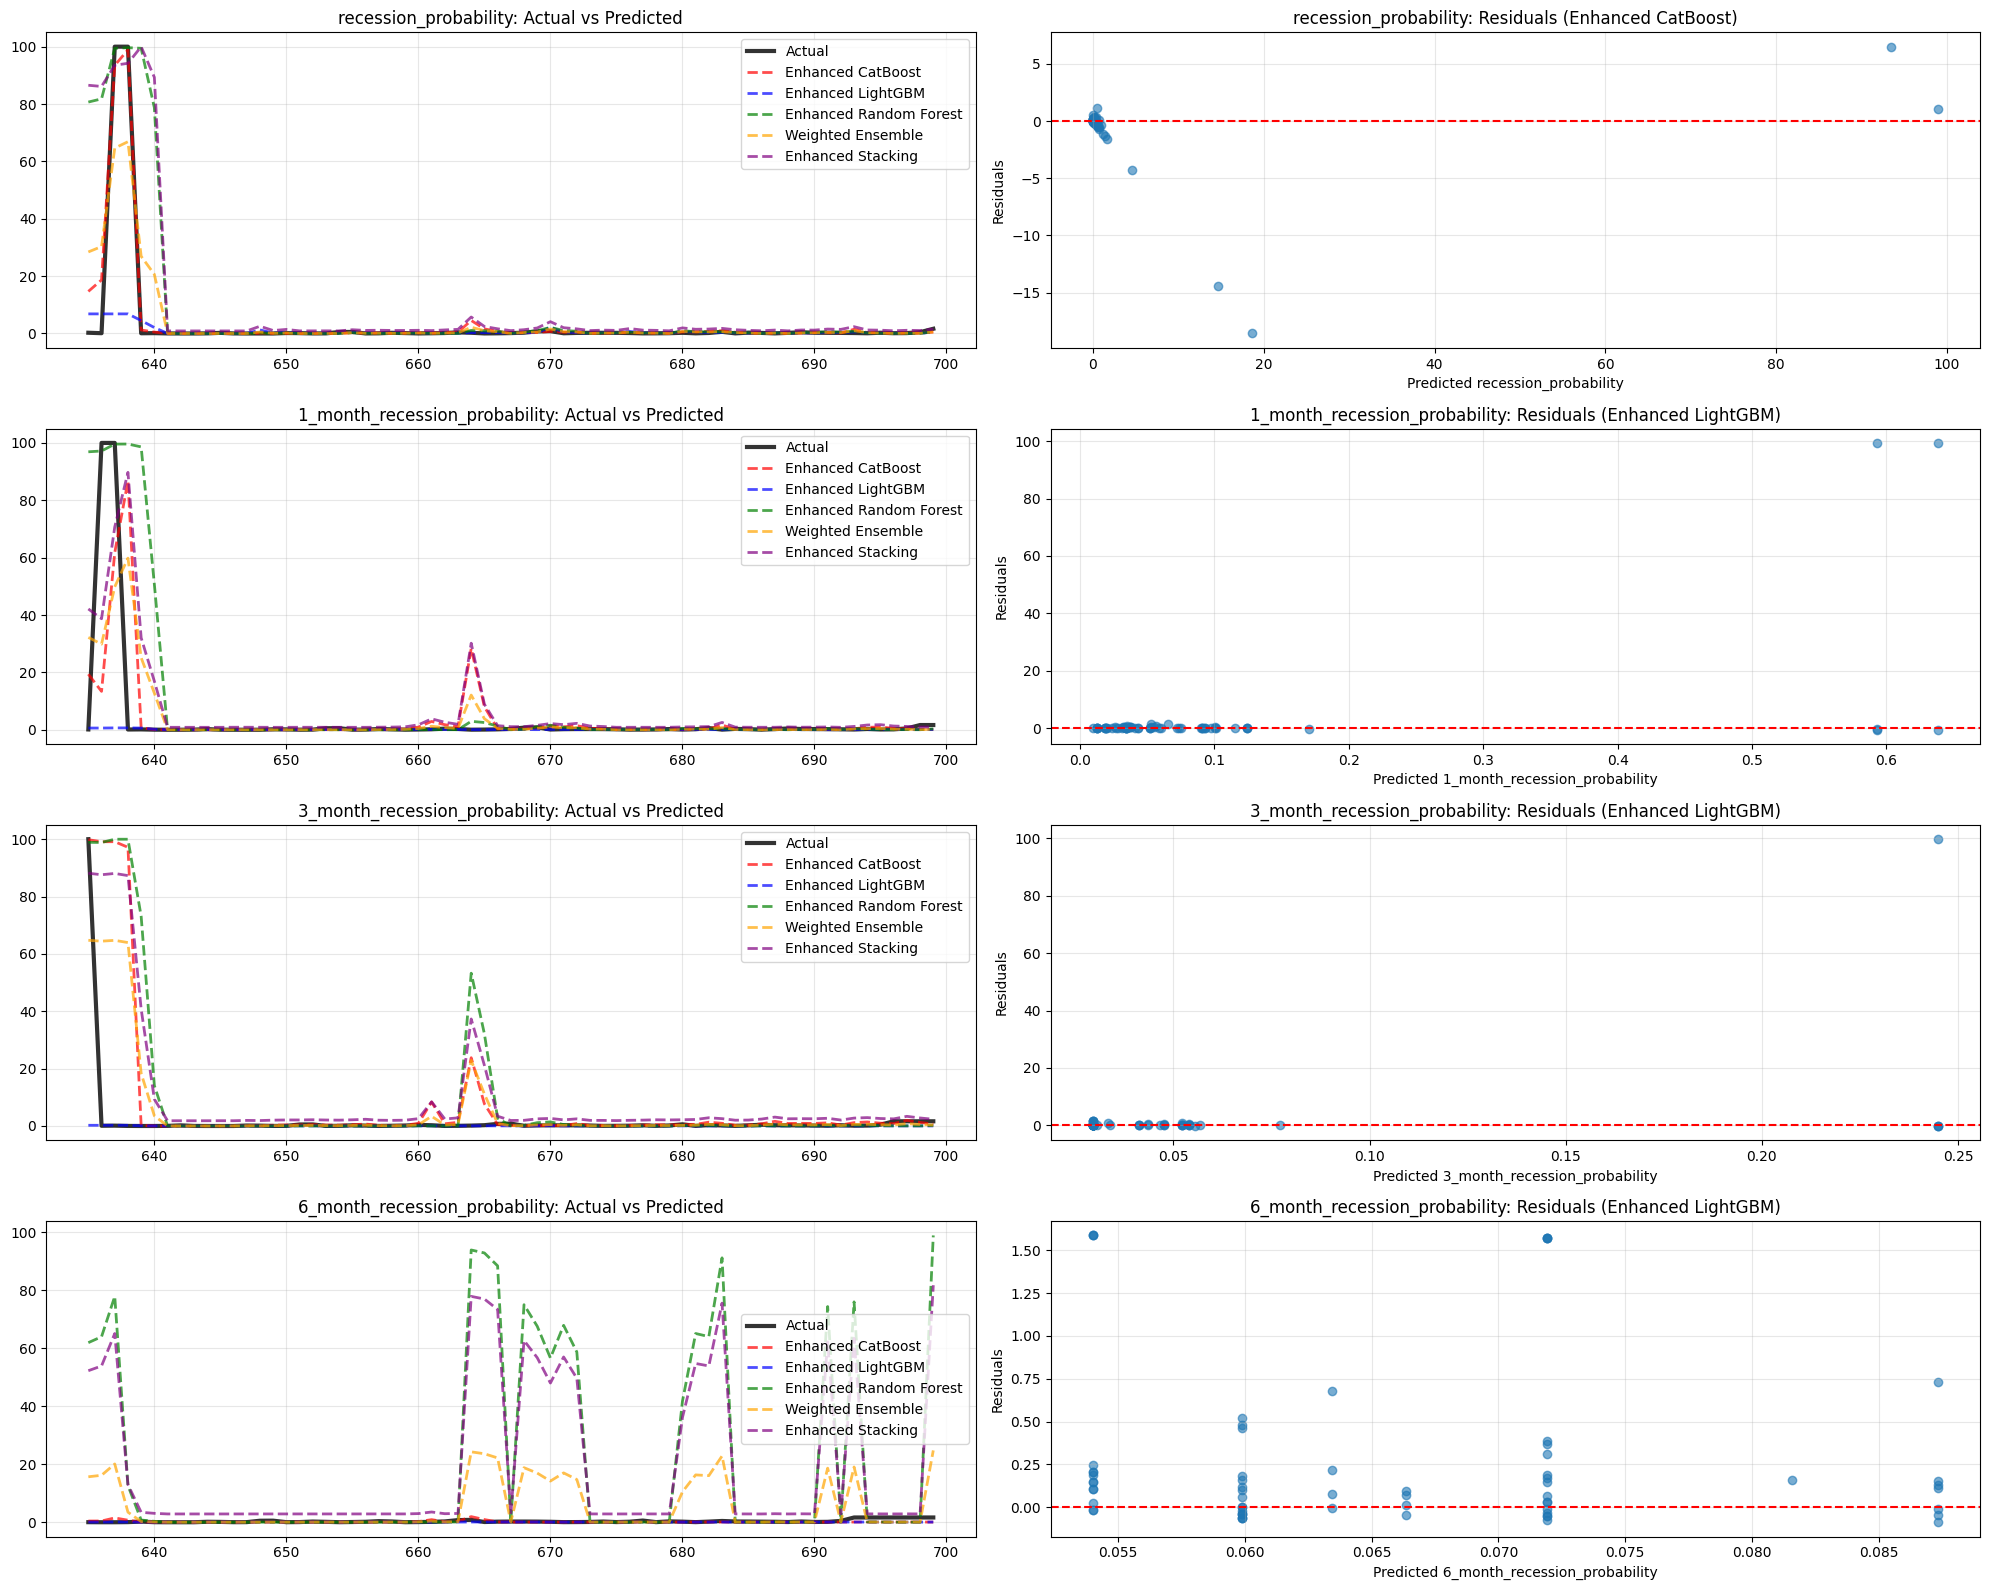


COMPREHENSIVE MODEL COMPARISON

Overall Performance Summary (Average across all targets):
                           MAE     RMSE         R2      MAPE  Training_Time
Model                                                                      
Enhanced LightGBM       2.1760  11.6932    -0.0677   29.7208         0.5220
Enhanced CatBoost       2.8013  10.4071    -0.4060  226.9620         2.5796
Weighted Ensemble       4.2768  11.9593  -101.3168  333.7814         5.1299
Enhanced Stacking       9.7658  22.9280 -1149.3048  909.7521        51.2377
Enhanced Random Forest  9.8219  26.7236 -1642.3942  951.7047         2.1384

Detailed Performance by Target:

MAE:
Model                          Enhanced CatBoost  Enhanced LightGBM  \
Target                                                                
1_month_recession_probability             4.4514             3.2633   
3_month_recession_probability             5.4751             1.7807   
6_month_recession_probability             0.3672      

In [18]:
# Run enhanced pipeline
models, predictions, metrics, predictor = demo_enhanced_pipeline(df)